In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
def load_data(filename, include_rows):
    df = pd.read_excel(filename)
    df = df.loc[include_rows]
    return df.values, df


def plot_data(df, title_name):
    x = df['Result X']
    df = df.drop(columns=['Result X'])

    for column in df.columns:
        plt.plot(x, df[column], label=column)

    plt.title(title_name)
    plt.xlabel('Voltage')
    plt.ylabel('Current')
    plt.legend(loc='best')
    plt.show()


def objective_function(x, data, range_size):
    voltages = data[:, 0]
    currents = data[:, 1]

    start_voltage = x[0]
    end_voltage = start_voltage + range_size

    # Ensure end voltage does not exceed the maximum voltage in the data
    if end_voltage > voltages.max():
        end_voltage = voltages.max()

    idx_range = np.where((voltages >= start_voltage) &
                         (voltages <= end_voltage))[0]
    total_current = np.sum(currents[idx_range])
    return -total_current  # Negative sign to convert maximization to minimization


def initialize_population(pop_size, dim, bounds, range_size):
    # Ensure that the initialized population respects the range constraint
    pop = np.random.uniform(bounds[0], bounds[1] - range_size, (pop_size, dim))
    return pop


def update_position(pop, alpha, beta, delta, a, bounds, range_size):
    pop_size, dim = pop.shape
    new_pop = np.zeros((pop_size, dim))

    for i in range(pop_size):
        for j in range(dim):
            r1, r2 = np.random.rand(), np.random.rand()
            A1 = 2 * a * r1 - a
            C1 = 2 * r2

            D_alpha = np.abs(C1 * alpha[j] - pop[i, j])
            X1 = alpha[j] - A1 * D_alpha

            r1, r2 = np.random.rand(), np.random.rand()
            A2 = 2 * a * r1 - a
            C2 = 2 * r2

            D_beta = np.abs(C2 * beta[j] - pop[i, j])
            X2 = beta[j] - A2 * D_beta

            r1, r2 = np.random.rand(), np.random.rand()
            A3 = 2 * a * r1 - a
            C3 = 2 * r2

            D_delta = np.abs(C3 * delta[j] - pop[i, j])
            X3 = delta[j] - A3 * D_delta

            new_pop[i, j] = (X1 + X2 + X3) / 3

        new_pop[i, :] = np.clip(
            new_pop[i, :], bounds[0], bounds[1] - range_size)

    return new_pop


def gwo(objective_function, bounds, dim, pop_size, max_iter, data, range_size):
    pop = initialize_population(pop_size, dim, bounds, range_size)
    alpha, beta, delta = np.zeros(dim), np.zeros(dim), np.zeros(dim)
    alpha_score, beta_score, delta_score = float(
        "inf"), float("inf"), float("inf")

    convergence_curve = np.zeros(max_iter)

    for t in range(max_iter):
        for i in range(pop_size):
            fitness = objective_function(pop[i, :], data, range_size)

            if fitness < alpha_score:
                delta_score = beta_score
                delta = beta.copy()

                beta_score = alpha_score
                beta = alpha.copy()

                alpha_score = fitness
                alpha = pop[i, :].copy()

            elif fitness < beta_score:
                delta_score = beta_score
                delta = beta.copy()

                beta_score = fitness
                beta = pop[i, :].copy()

            elif fitness < delta_score:
                delta_score = fitness
                delta = pop[i, :].copy()

        a = 2 - t * (2 / max_iter)

        pop = update_position(pop, alpha, beta, delta, a, bounds, range_size)
        convergence_curve[t] = alpha_score

        # Negative sign to show actual best score
        print(f"Iteration: {t+1}, Best Score: {-alpha_score}")

    return alpha, -alpha_score, convergence_curve

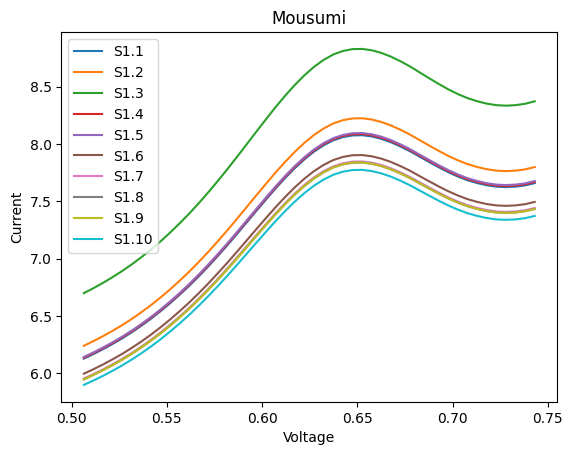

Iteration: 1, Best Score: 320.56372982351155
Iteration: 2, Best Score: 320.56372982351155
Iteration: 3, Best Score: 320.56372982351155
Iteration: 4, Best Score: 320.56372982351155
Iteration: 5, Best Score: 320.56372982351155
Iteration: 6, Best Score: 320.56372982351155
Iteration: 7, Best Score: 320.56372982351155
Iteration: 8, Best Score: 321.4355363947111
Iteration: 9, Best Score: 321.7749149985464
Iteration: 10, Best Score: 321.7749149985464
Iteration: 11, Best Score: 321.7749149985464
Iteration: 12, Best Score: 321.7749149985464
Iteration: 13, Best Score: 321.7749149985464
Iteration: 14, Best Score: 321.7749149985464
Iteration: 15, Best Score: 321.7749149985464
Iteration: 16, Best Score: 321.7749149985464
Iteration: 17, Best Score: 321.7749149985464
Iteration: 18, Best Score: 321.7749149985464
Iteration: 19, Best Score: 321.7749149985464
Iteration: 20, Best Score: 321.7749149985464
Iteration: 21, Best Score: 321.7749149985464
Iteration: 22, Best Score: 321.7749149985464
Iteration: 2

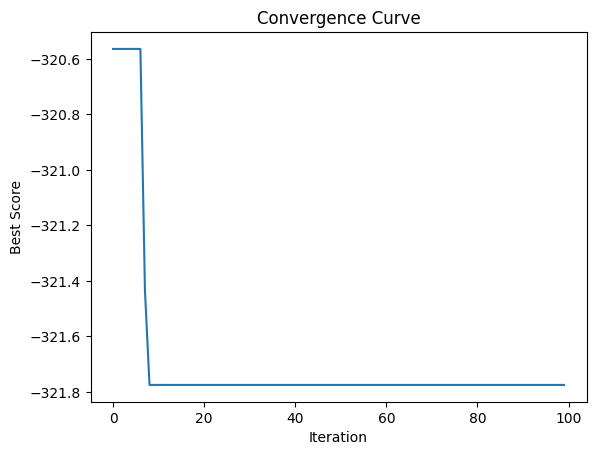

In [24]:
# Main function
if __name__ == "__main__":
    filename = 'sample1.xlsx'  # Replace with your actual file name
    include_rows = range(180, 228)  # Include rows between 180 and 228
    data, df = load_data(filename, include_rows)

    # Plot the data
    title_name = 'Mousumi'
    plot_data(df, title_name)

    # Parameters for GWO
    bounds = [data[:, 0].min(), data[:, 0].max()]  # Voltage range
    dim = 1  # One dimension for start of the range
    pop_size = 20
    max_iter = 100
    # Define the desired range size here (adjust based on your data)
    range_size = 0.02

    # Prepare data for optimization
    data_for_optimization = np.column_stack(
        (data[:, 0], data[:, 1:].sum(axis=1)))

    best_solution, best_score, convergence_curve = gwo(
        objective_function, bounds, dim, pop_size, max_iter, data_for_optimization, range_size)

    best_start_voltage = best_solution[0]
    best_end_voltage = best_start_voltage + range_size
    if best_end_voltage > data[:, 0].max():
        best_end_voltage = data[:, 0].max()

    print(f"Best Voltage Range: {best_start_voltage} to {best_end_voltage}")
    print(f"Highest Total Current: {best_score}")

    # Plot the convergence curve
    plt.plot(convergence_curve)
    plt.title('Convergence Curve')
    plt.xlabel('Iteration')
    plt.ylabel('Best Score')
    plt.show()

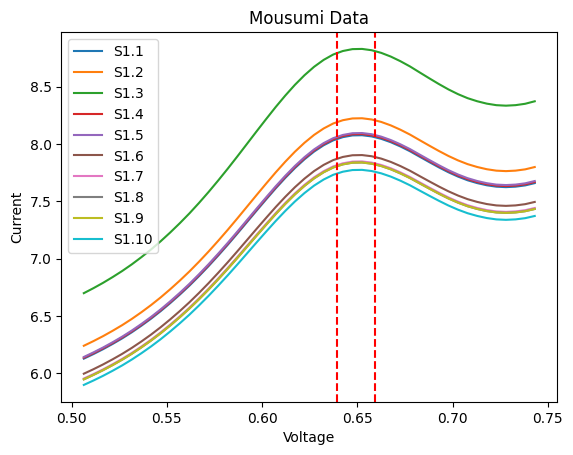

In [25]:
filename = 'sample1.xlsx'  # Replace with your actual file name
include_rows = range(180, 228)  # Include rows between 180 and 228
data, df = load_data(filename, include_rows)

x = df['Result X']
df = df.drop(columns=['Result X'])

for column in df.columns:
    plt.plot(x, df[column], label=column)

# Example list of best_values to plot vertical lines at
# Adding vertical lines at the best_values points
best = [best_start_voltage, best_end_voltage]

for xv in best:
    plt.axvline(x=xv, color='r', linestyle='--')

title_name = 'Mousumi Data'
plt.title(title_name)
plt.xlabel('Voltage')
plt.ylabel('Current')
plt.legend(loc='best')
plt.show()

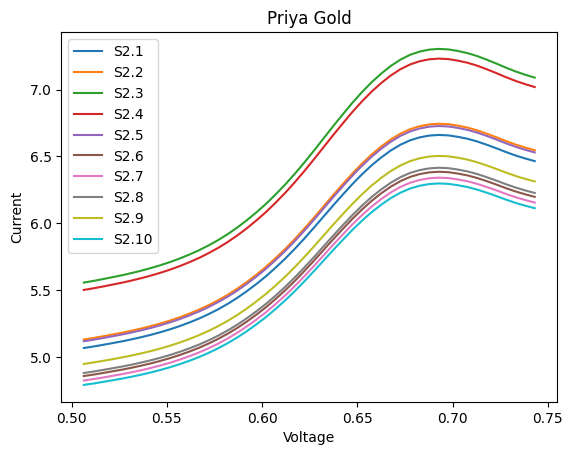

Iteration: 1, Best Score: 266.21818885075356
Iteration: 2, Best Score: 266.21818885075356
Iteration: 3, Best Score: 266.21818885075356
Iteration: 4, Best Score: 266.21818885075356
Iteration: 5, Best Score: 266.21818885075356
Iteration: 6, Best Score: 266.21818885075356
Iteration: 7, Best Score: 266.21818885075356
Iteration: 8, Best Score: 266.21818885075356
Iteration: 9, Best Score: 266.21818885075356
Iteration: 10, Best Score: 266.21818885075356
Iteration: 11, Best Score: 266.21818885075356
Iteration: 12, Best Score: 266.21818885075356
Iteration: 13, Best Score: 266.21818885075356
Iteration: 14, Best Score: 266.21818885075356
Iteration: 15, Best Score: 266.21818885075356
Iteration: 16, Best Score: 266.21818885075356
Iteration: 17, Best Score: 266.21818885075356
Iteration: 18, Best Score: 266.21818885075356
Iteration: 19, Best Score: 266.21818885075356
Iteration: 20, Best Score: 266.21818885075356
Iteration: 21, Best Score: 266.21818885075356
Iteration: 22, Best Score: 266.218188850753

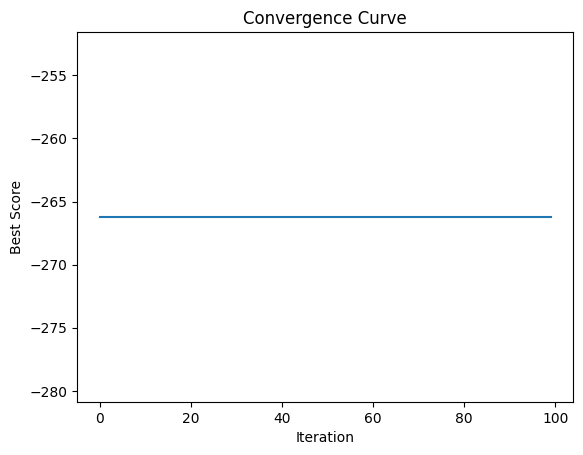

In [30]:
# Main function
if __name__ == "__main__":
    filename = 'sample2.xlsx'  # Replace with your actual file name
    include_rows = range(180, 228)  # Include rows between 180 and 228
    data, df = load_data(filename, include_rows)

    # Plot the data
    title_name = 'Priya Gold'
    plot_data(df, title_name)

    # Parameters for GWO
    bounds = [data[:, 0].min(), data[:, 0].max()]  # Voltage range
    dim = 1  # One dimension for start of the range
    pop_size = 20
    max_iter = 100
    # Define the desired range size here (adjust based on your data)
    range_size = 0.02

    # Prepare data for optimization
    data_for_optimization = np.column_stack(
        (data[:, 0], data[:, 1:].sum(axis=1)))

    best_solution, best_score, convergence_curve = gwo(
        objective_function, bounds, dim, pop_size, max_iter, data_for_optimization, range_size)

    best_start_voltage = best_solution[0]
    best_end_voltage = best_start_voltage + range_size
    if best_end_voltage > data[:, 0].max():
        best_end_voltage = data[:, 0].max()

    print(f"Best Voltage Range: {best_start_voltage} to {best_end_voltage}")
    print(f"Highest Total Current: {best_score}")

    # Plot the convergence curve
    plt.plot(convergence_curve)
    plt.title('Convergence Curve')
    plt.xlabel('Iteration')
    plt.ylabel('Best Score')
    plt.show()

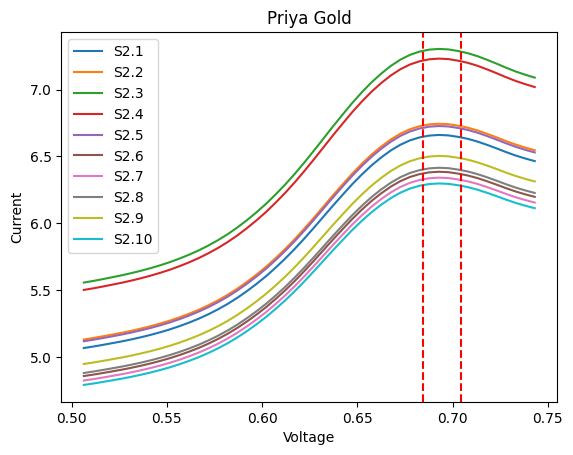

In [32]:
filename = 'sample2.xlsx'  # Replace with your actual file name
include_rows = range(180, 228)  # Include rows between 180 and 228
data, df = load_data(filename, include_rows)

x = df['Result X']
df = df.drop(columns=['Result X'])

for column in df.columns:
    plt.plot(x, df[column], label=column)

# Example list of best_values to plot vertical lines at
# Adding vertical lines at the best_values points
best = [best_start_voltage, best_end_voltage]

for xv in best:
    plt.axvline(x=xv, color='r', linestyle='--')

title_name = 'Priya Gold'
plt.title(title_name)
plt.xlabel('Voltage')
plt.ylabel('Current')
plt.legend(loc='best')
plt.show()

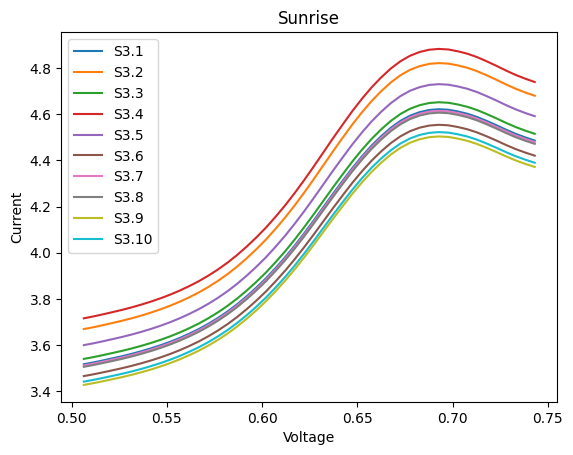

Iteration: 1, Best Score: 185.59702288206762
Iteration: 2, Best Score: 185.7180821173258
Iteration: 3, Best Score: 185.8845747388841
Iteration: 4, Best Score: 185.8845747388841
Iteration: 5, Best Score: 185.8845747388841
Iteration: 6, Best Score: 185.8845747388841
Iteration: 7, Best Score: 185.8845747388841
Iteration: 8, Best Score: 185.8845747388841
Iteration: 9, Best Score: 185.8845747388841
Iteration: 10, Best Score: 185.8845747388841
Iteration: 11, Best Score: 185.8845747388841
Iteration: 12, Best Score: 185.8845747388841
Iteration: 13, Best Score: 185.8845747388841
Iteration: 14, Best Score: 185.8845747388841
Iteration: 15, Best Score: 185.8845747388841
Iteration: 16, Best Score: 185.8845747388841
Iteration: 17, Best Score: 185.8845747388841
Iteration: 18, Best Score: 185.8845747388841
Iteration: 19, Best Score: 185.8845747388841
Iteration: 20, Best Score: 185.8845747388841
Iteration: 21, Best Score: 185.8845747388841
Iteration: 22, Best Score: 185.8845747388841
Iteration: 23, Bes

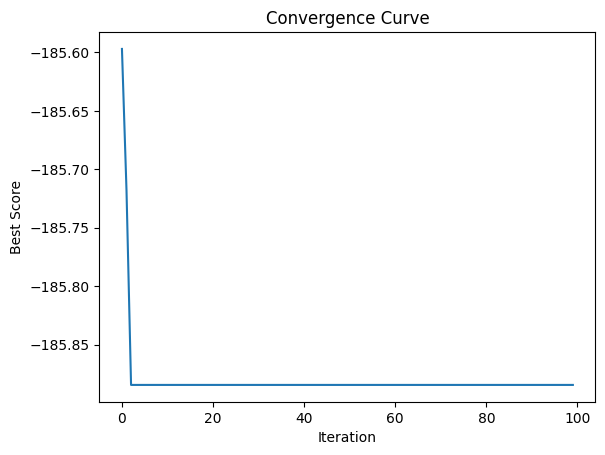

In [33]:
# Main function
if __name__ == "__main__":
    filename = 'sample3.xlsx'  # Replace with your actual file name
    include_rows = range(180, 228)  # Include rows between 180 and 228
    data, df = load_data(filename, include_rows)

    # Plot the data
    title_name = 'Sunrise'
    plot_data(df, title_name)

    # Parameters for GWO
    bounds = [data[:, 0].min(), data[:, 0].max()]  # Voltage range
    dim = 1  # One dimension for start of the range
    pop_size = 20
    max_iter = 100
    # Define the desired range size here (adjust based on your data)
    range_size = 0.02

    # Prepare data for optimization
    data_for_optimization = np.column_stack(
        (data[:, 0], data[:, 1:].sum(axis=1)))

    best_solution, best_score, convergence_curve = gwo(
        objective_function, bounds, dim, pop_size, max_iter, data_for_optimization, range_size)

    best_start_voltage = best_solution[0]
    best_end_voltage = best_start_voltage + range_size
    if best_end_voltage > data[:, 0].max():
        best_end_voltage = data[:, 0].max()

    print(f"Best Voltage Range: {best_start_voltage} to {best_end_voltage}")
    print(f"Highest Total Current: {best_score}")

    # Plot the convergence curve
    plt.plot(convergence_curve)
    plt.title('Convergence Curve')
    plt.xlabel('Iteration')
    plt.ylabel('Best Score')
    plt.show()

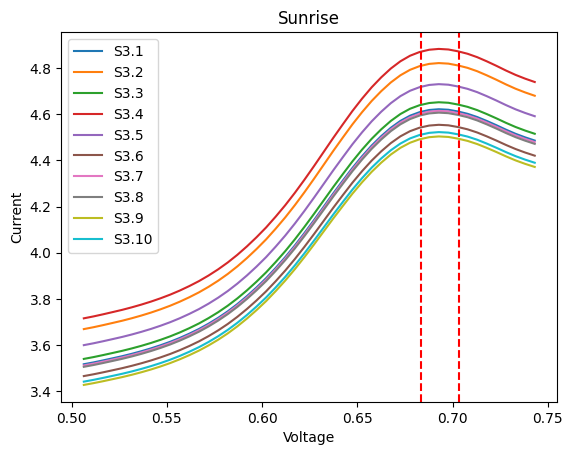

In [35]:
filename = 'sample3.xlsx'  # Replace with your actual file name
include_rows = range(180, 228)  # Include rows between 180 and 228
data, df = load_data(filename, include_rows)

x = df['Result X']
df = df.drop(columns=['Result X'])

for column in df.columns:
    plt.plot(x, df[column], label=column)

# Example list of best_values to plot vertical lines at
# Adding vertical lines at the best_values points
best = [best_start_voltage, best_end_voltage]

for xv in best:
    plt.axvline(x=xv, color='r', linestyle='--')

title_name = 'Sunrise'
plt.title(title_name)
plt.xlabel('Voltage')
plt.ylabel('Current')
plt.legend(loc='best')
plt.show()

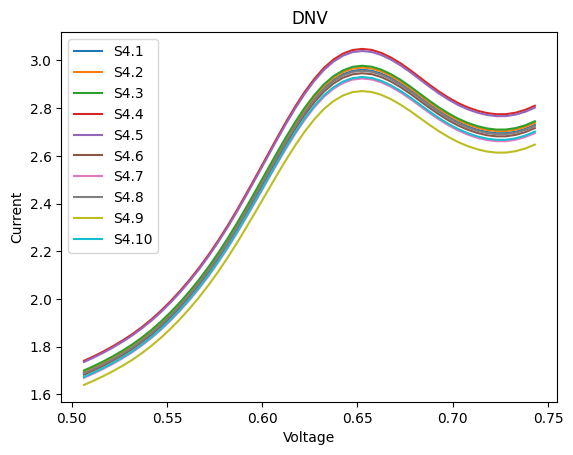

Iteration: 1, Best Score: 117.06207945350353
Iteration: 2, Best Score: 117.95611618976947
Iteration: 3, Best Score: 117.95611618976947
Iteration: 4, Best Score: 118.26245726134606
Iteration: 5, Best Score: 118.26245726134606
Iteration: 6, Best Score: 118.26245726134606
Iteration: 7, Best Score: 118.26245726134606
Iteration: 8, Best Score: 118.26245726134606
Iteration: 9, Best Score: 118.26245726134606
Iteration: 10, Best Score: 118.26245726134606
Iteration: 11, Best Score: 118.26245726134606
Iteration: 12, Best Score: 118.26245726134606
Iteration: 13, Best Score: 118.26245726134606
Iteration: 14, Best Score: 118.26245726134606
Iteration: 15, Best Score: 118.26245726134606
Iteration: 16, Best Score: 118.26245726134606
Iteration: 17, Best Score: 118.26245726134606
Iteration: 18, Best Score: 118.26245726134606
Iteration: 19, Best Score: 118.26245726134606
Iteration: 20, Best Score: 118.26245726134606
Iteration: 21, Best Score: 118.26245726134606
Iteration: 22, Best Score: 118.262457261346

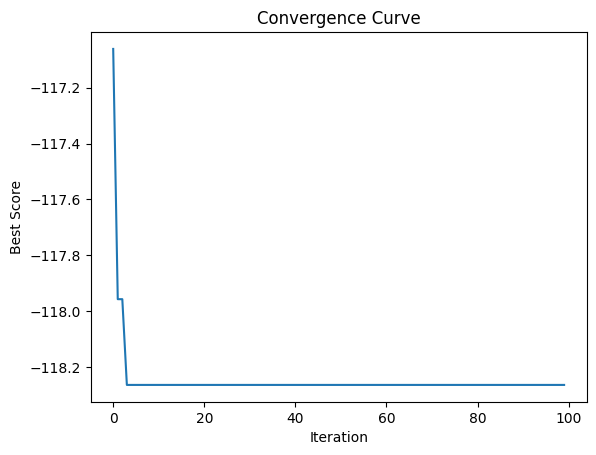

In [37]:
# Main function
if __name__ == "__main__":
    filename = 'sample4.xlsx'  # Replace with your actual file name
    include_rows = range(180, 228)  # Include rows between 180 and 228
    data, df = load_data(filename, include_rows)

    # Plot the data
    title_name = 'DNV'
    plot_data(df, title_name)

    # Parameters for GWO
    bounds = [data[:, 0].min(), data[:, 0].max()]  # Voltage range
    dim = 1  # One dimension for start of the range
    pop_size = 20
    max_iter = 100
    # Define the desired range size here (adjust based on your data)
    range_size = 0.02

    # Prepare data for optimization
    data_for_optimization = np.column_stack(
        (data[:, 0], data[:, 1:].sum(axis=1)))

    best_solution, best_score, convergence_curve = gwo(
        objective_function, bounds, dim, pop_size, max_iter, data_for_optimization, range_size)

    best_start_voltage = best_solution[0]
    best_end_voltage = best_start_voltage + range_size
    if best_end_voltage > data[:, 0].max():
        best_end_voltage = data[:, 0].max()

    print(f"Best Voltage Range: {best_start_voltage} to {best_end_voltage}")
    print(f"Highest Total Current: {best_score}")

    # Plot the convergence curve
    plt.plot(convergence_curve)
    plt.title('Convergence Curve')
    plt.xlabel('Iteration')
    plt.ylabel('Best Score')
    plt.show()

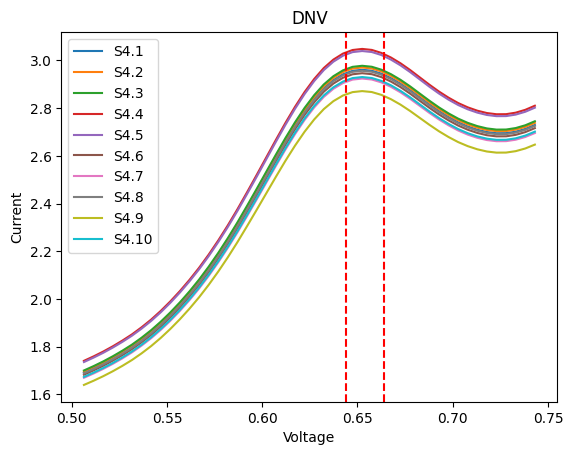

In [39]:
filename = 'sample4.xlsx'  # Replace with your actual file name
include_rows = range(180, 228)  # Include rows between 180 and 228
data, df = load_data(filename, include_rows)

x = df['Result X']
df = df.drop(columns=['Result X'])

for column in df.columns:
    plt.plot(x, df[column], label=column)

# Example list of best_values to plot vertical lines at
# Adding vertical lines at the best_values points
best = [best_start_voltage, best_end_voltage]

for xv in best:
    plt.axvline(x=xv, color='r', linestyle='--')

title_name = 'DNV'
plt.title(title_name)
plt.xlabel('Voltage')
plt.ylabel('Current')
plt.legend(loc='best')
plt.show()